In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For Jupyter; remove if you use plain .py
%matplotlib inline

# === 1. Load the CSV ===
csi_path = "/home/afrose.4/CSI Analysis/srs-indoor-ota/srs_csi_20260114_151853_1.csv"
df = pd.read_csv(csi_path)

# === 2. Quick inspection ===
print("First 5 rows:")
print(df.head())

print("\nColumn dtypes:")
print(df.dtypes)

print("\nBasic info:")
print("Total rows:", len(df))
print("Unique entry_num:", df['entry_num'].nunique())
print("Unique subcarriers:", df['subcarrier'].nunique())
print("RX ports:", df['rx_port'].unique())
print("TX ports:", df['tx_port'].unique())

# If 'magnitude' is present, also show its range
if 'magnitude' in df.columns:
    print("\nMagnitude stats:")
    print(df['magnitude'].describe())



First 5 rows:
   entry_num      timestamp_us          timestamp_readable  rx_port  tx_port  \
0          1  1768429133154594  2026-01-14 17:18:53.154594        0        0   
1          1  1768429133154594  2026-01-14 17:18:53.154594        0        0   
2          1  1768429133154594  2026-01-14 17:18:53.154594        0        0   
3          1  1768429133154594  2026-01-14 17:18:53.154594        0        0   
4          1  1768429133154594  2026-01-14 17:18:53.154594        0        0   

   num_tones  subcarrier  symbol      real      imag  magnitude  phase_deg  
0        312          12      13  0.019597  0.451657   0.452082      87.52  
1        312          16      13  0.024932  0.447769   0.448462      86.81  
2        312          20      13  0.025346  0.446290   0.447010      86.75  
3        312          24      13  0.028492  0.446614   0.447521      86.35  
4        312          28      13  0.030902  0.446590   0.447658      86.04  

Column dtypes:
entry_num               int

In [94]:
import numpy as np

# === 2.1 Add complex CSI and magnitude in dB ===
df['H_complex'] = df['real'] + 1j * df['imag']
df['mag_db'] = 20 * np.log10(df['magnitude'] + 1e-12)

print("mag_db stats (dB):")
print(df['mag_db'].describe())

# === 2.2 Check that each SRS entry has 144 tones ===
tones_per_entry = df.groupby('entry_num')['subcarrier'].nunique()

print("\nPer-entry number of subcarriers (should be all 144):")
print(tones_per_entry.describe())
print("\nAny entries with missing tones?")
print(tones_per_entry[tones_per_entry != 144].head())



mag_db stats (dB):
count    939120.000000
mean        -18.040020
std           3.316292
min         -95.391021
25%         -20.429177
50%         -17.602351
75%         -16.091639
max          -3.045969
Name: mag_db, dtype: float64

Per-entry number of subcarriers (should be all 144):
count    3010.0
mean      312.0
std         0.0
min       312.0
25%       312.0
50%       312.0
75%       312.0
max       312.0
Name: subcarrier, dtype: float64

Any entries with missing tones?
entry_num
1    312
2    312
3    312
4    312
5    312
Name: subcarrier, dtype: int64


In [95]:
import ipywidgets as widgets
from ipywidgets import interact

def plot_entry(df, entry_num, rx_port=0, tx_port=0):
    """Plot magnitude & phase vs subcarrier for a single CSI entry."""
    
    data = df[(df['entry_num'] == entry_num) &
              (df['rx_port'] == rx_port) &
              (df['tx_port'] == tx_port)].sort_values('subcarrier')
    
    if data.empty:
        print("No data found for entry:", entry_num)
        return
    
    subc = data['subcarrier'].to_numpy()
    mag_db = data['mag_db'].to_numpy()
    phase_deg = data['phase_deg'].to_numpy()

    fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    # Magnitude
    axes[0].plot(subc, mag_db, '.-')
    axes[0].set_ylabel('|H(k)| [dB]', fontsize=12)
    axes[0].set_title(f'CSI Frequency Response — Entry {entry_num}', fontsize=14)
    axes[0].grid(True, alpha=0.4)

    # Phase
    axes[1].plot(subc, phase_deg, '.-', color='orange')
    axes[1].set_ylabel('Phase [deg]', fontsize=12)
    axes[1].set_xlabel('Subcarrier Index', fontsize=12)
    axes[1].grid(True, alpha=0.4)

    plt.tight_layout()
    plt.show()


# === Create interactive widget ===

min_entry = int(df['entry_num'].min())
max_entry = int(df['entry_num'].max())

interact(
    plot_entry,
    df=widgets.fixed(df),
    entry_num=widgets.IntSlider(
        min=min_entry,
        max=max_entry,
        step=1,
        value=min_entry,
        description='Entry #',
        continuous_update=False
    ),
    rx_port=widgets.Dropdown(options=[0], value=0, description='RX Port'),
    tx_port=widgets.Dropdown(options=[0], value=0, description='TX Port')
)


interactive(children=(IntSlider(value=1, continuous_update=False, description='Entry #', max=3010, min=1), Dro…

<function __main__.plot_entry(df, entry_num, rx_port=0, tx_port=0)>

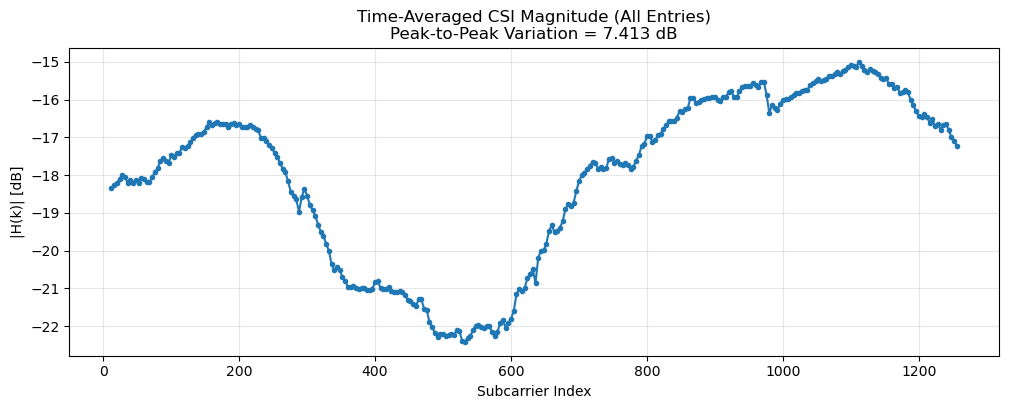

Time-Averaged Magnitude Statistics:
        subcarrier      mag_db
count   312.000000  312.000000
mean    634.000000  -18.040020
std     360.843456    2.234902
min      12.000000  -22.409158
25%     323.000000  -20.002249
50%     634.000000  -17.498152
75%     945.000000  -16.133804
max    1256.000000  -14.996278

Overall Frequency Flatness (Peak-to-Peak): 7.413 dB


In [96]:
def plot_time_averaged_mag(df, rx_port=0, tx_port=0):
    df_sel = df[(df['rx_port'] == rx_port) & (df['tx_port'] == tx_port)]
    
    avg_mag = (df_sel
               .groupby('subcarrier')['mag_db']
               .mean()
               .reset_index())

    peak_to_peak = avg_mag['mag_db'].max() - avg_mag['mag_db'].min()

    plt.figure(figsize=(12, 4))
    plt.plot(avg_mag['subcarrier'], avg_mag['mag_db'], '.-')
    plt.title(f"Time-Averaged CSI Magnitude (All Entries)\n"
              f"Peak-to-Peak Variation = {peak_to_peak:.3f} dB")
    plt.xlabel("Subcarrier Index")
    plt.ylabel("|H(k)| [dB]")
    plt.grid(True, alpha=0.3)
    plt.show()

    print("Time-Averaged Magnitude Statistics:")
    print(avg_mag.describe())
    print(f"\nOverall Frequency Flatness (Peak-to-Peak): {peak_to_peak:.3f} dB")

# === Run ===
plot_time_averaged_mag(df)


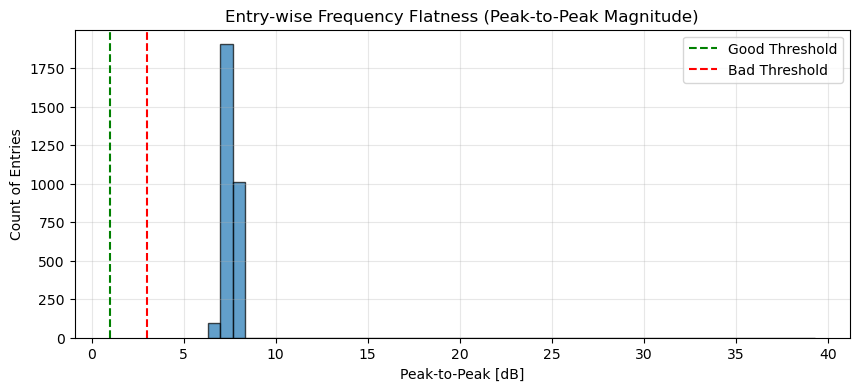

class
Bad    3010
Name: count, dtype: int64


In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def classify_entry_flatness(df, threshold_good=1.0, threshold_bad=3.0):
    """
    Classify each CSI entry based on frequency-domain flatness.
    
    Good: peak-to-peak < threshold_good (default < 1 dB)
    Medium: threshold_good <= pp < threshold_bad
    Bad: peak-to-peak >= threshold_bad (likely noise)
    """

    pp_values = (
        df.groupby('entry_num')['mag_db'].apply(lambda x: x.max() - x.min())
        .rename("peak_to_peak")
    )

    df_pp = pp_values.reset_index()

    def classify(pp):
        if pp < threshold_good:
            return "Good"
        elif pp < threshold_bad:
            return "Medium"
        else:
            return "Bad"

    df_pp["class"] = df_pp["peak_to_peak"].apply(classify)

    # Plot histogram
    plt.figure(figsize=(10, 4))
    plt.hist(df_pp["peak_to_peak"], bins=50, edgecolor='k', alpha=0.7)
    plt.axvline(threshold_good, color='g', linestyle='--', label='Good Threshold')
    plt.axvline(threshold_bad, color='r', linestyle='--', label='Bad Threshold')
    plt.title("Entry-wise Frequency Flatness (Peak-to-Peak Magnitude)")
    plt.xlabel("Peak-to-Peak [dB]")
    plt.ylabel("Count of Entries")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    print(df_pp["class"].value_counts())
    return df_pp

# ==== Run classification ====
df_flatness = classify_entry_flatness(df)


In [98]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

def impulse_response_plot(entry_num, rx_port=0, tx_port=0):
    """Interactive impulse response (IFFT) viewer for CSI."""
    
    data = df[(df['entry_num'] == entry_num) &
              (df['rx_port'] == rx_port) &
              (df['tx_port'] == tx_port)].sort_values('subcarrier')

    if data.empty:
        print("No CSI for this entry.")
        return
    
    # Extract complex CSI
    H = data['H_complex'].to_numpy()
    h = np.fft.ifft(H)
    h_mag = np.abs(h)

    # Older Matplotlib: stem without use_line_collection
    markerline, stemlines, baseline = plt.stem(h_mag)
    plt.setp(markerline, marker='o', markersize=4)
    plt.setp(stemlines, linewidth=1)
    plt.setp(baseline, linewidth=0)

    plt.title(f"Impulse Response (IFFT) — Entry {entry_num}")
    plt.xlabel("Delay Tap Index")
    plt.ylabel("|h[n]|")
    plt.grid(True, alpha=0.3)
    plt.show()


# === Widget ===

min_entry = int(df['entry_num'].min())
max_entry = int(df['entry_num'].max())

interact(
    impulse_response_plot,
    entry_num=widgets.IntSlider(
        min=min_entry,
        max=max_entry,
        value=min_entry,
        step=1,
        continuous_update=False,
        description='Entry #'
    ),
    rx_port=widgets.Dropdown(options=[0], value=0, description="RX Port"),
    tx_port=widgets.Dropdown(options=[0], value=0, description="TX Port")
)


interactive(children=(IntSlider(value=1, continuous_update=False, description='Entry #', max=3010, min=1), Dro…

<function __main__.impulse_response_plot(entry_num, rx_port=0, tx_port=0)>